# Two-Layer Networks on CIFAR10, Cyclical Learning Rate Schedule, and Bayesian Hyperparameter Search

## Contents

* [Introduction](#introduction)
* [Imports](#imports)
* [Importing Dataset and Data Pre-Processing](#importing-dataset-and-data-pre-processing)
* [Numerical Gradient Check](#numerical-gradient-check)
* [Training and Results](#training-and-results)
    - [One-Layer Network with SVM Classifier](#one-layer-network-with-svm-classifier)
    - [One-Layer Network with Softmax Classifier](#one-layer-network-with-softmax-classifier)
* [Playing with Hyperparameters](#playing-with-hyperparameters)

## Introduction <a class="anchor" id="introduction"></a>

In this notebook, a two-layer network with multiple outputs is trained and tested to classify images from the CIFAR-10 dataset. The network is trained using mini-batch gradient descent applied to a cost function that computes the cross-entropy loss of the classifier applied to the labelled training data and an L2 regularization term on the weight matrix. The learning rate uses a cyclical learning rate schedule. Furthemore, a Bayesian hyperparameter search is conducted with the use of external libraries.

In my implementation, I built on top of the code presented in the ```one-layer.ipynb``` notebook. At the core of my implementation is the ```Dense``` layer (fully-connected layer that can have activations ```SoftmaxActivation```, ```LinearActivation```, and ```ReLUActivation```. The learnable (or trainable) parameters of the ```Dense``` layer can be initialized with the ```XavierInitializer```, and can be regularized with the ```L2Regularizer```. A ```Model``` comprises any number of layers, its loss function is ```CategoricalCrossEntropyLoss```. The trainable parameters are optimized with the mini-batch gradient descent algorithm via the ```SGDOptimizer``` and the learning rate schedule of the optimizer is [```LRCyclingSchedule```](https://arxiv.org/abs/1506.01186) . The ```Model``` is first compiled with the loss function, some metrics such as the ```AccuracyMetrics```, and the optimizer, and then it is fit to the data with the ```Model.fit``` method.

In this notebook, I implemented a two-layer neural network for multi-class classification such that both of the ```Dense``` layers' trainable parameters are initialized with the ```XavierInitializer``` and regularized with the ```L2Regularizer```. The input dimension and the output dimension of the first ```Dense``` layer are 3072 (=32x32x3) and 50, respectively. The input and output dimensions of the second ```Dense``` layer are 50 and 10 (=the number of class labels), respectively. The first ```Dense``` layer has ```ReLUActivation```, and the second ```Dense``` layer has ```SoftmaxActivation```. The ```Model``` is then compiled with the ```CategoricalCrossEntropyLoss``` loss function, the ```AccuracyMetrics``` performance metric, and the ```SGDOptimizer``` optimizer that uses the ```LRCyclingSchedule``` learning rate schedule.

## Imports <a class="anchor" id="imports"></a>

Import the library parts and the required packages.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import pickle
from copy import deepcopy
from math import sqrt, ceil
import datetime
import sys
from itertools import product
import pandas as pd


from data_utils import load_cfar10_batch, load_label_names
from losses import CategoricalHingeLoss, CategoricalCrossEntropyLoss
from activations import LinearActivation, ReLUActivation, SoftmaxActivation
from initializers import NormalInitializer, XavierInitializer
from layers import Dense
from regularizers import L2Regularizer
from models import Model
from metrics import AccuracyMetrics
from optimizers import SGDOptimizer
from lr_schedules import LRConstantSchedule, LRExponentialDecaySchedule, LRCyclingSchedule
from viz_utils import plot_losses, plot_costs, plot_accuracies, plot_lrs
from grad_check import numerical_gradient_check_model

## Importing Dataset and Data Pre-Processing <a class="anchor" id="importing-dataset-and-data-pre-processing"></a>

In this notebook, for the sake of speed, the training set is ```data_batch_1```, the validation set is ```data_batch_2```, and the test set is ```test_batch```.

Pre-process datasets by standardization of features (subtract mean of each feature and divide by its standard deviation). Use the training mean and standard deviation on the validation and the test datasets! After this, the mean of each feature in the subsets should be around 0 and the standard deviation should be around 1.

For a finer breakdown of these steps, see ```one-layer.ipynb```.

In [2]:
# train set is batch 1, val set is batch 2, test set is test
path = os.path.join("data", "data_batch_1")
x_train_img, y_train = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_2")
x_val_img, y_val = load_cfar10_batch(path)

path = os.path.join("data", "test_batch")
x_test_img, y_test = load_cfar10_batch(path)

print(f"There are {np.unique(y_train).size} labels which are: \n{np.unique(y_train)}")

# check counts in datasets
print(f"The images are of shape: {x_train_img.shape[1:]}")
print(f"The set sizes are train: {x_train_img.shape[0]}, "
      f"validation: {x_val_img.shape[0]}, and test: {x_test_img.shape[0]}")

# assert balanced dataset
train_counts = np.unique(y_train, return_counts=True)[1]
train_ratios = train_counts / train_counts.sum()

val_counts = np.unique(y_val, return_counts=True)[1]
val_ratios = val_counts / val_counts.sum()

test_counts = np.unique(y_test, return_counts=True)[1]
test_ratios = test_counts / test_counts.sum()

# This is approximating the ratios, good enough
np.testing.assert_allclose(train_ratios, val_ratios, rtol=1e-1, atol=0)
np.testing.assert_allclose(val_ratios, test_ratios, rtol=1e-1, atol=0)

print(f"The class ratios in the training set are: {train_ratios}")
print(f"The class ratios in the validation set are: {val_ratios}")
print(f"The class ratios in the test set are: {test_ratios}")

x_train_un = x_train_img.reshape(x_train_img.shape[0], -1)
x_val_un = x_val_img.reshape(x_val_img.shape[0], -1)
x_test_un = x_test_img.reshape(x_test_img.shape[0], -1)

#x_train = x_train_un / 255.
#x_val = x_val_un / 255.
#x_test = x_test_un / 255.

mean = np.mean(x_train_un, axis=0).reshape(1, x_train_un.shape[1])
std = np.std(x_train_un, axis=0).reshape(1, x_train_un.shape[1])

x_train = (x_train_un - mean) / std
x_val = (x_val_un - mean) / std
x_test = (x_test_un - mean) / std

print(f"The means of the training set: {np.mean(x_train, axis=0)} "
      f"(#features = {np.mean(x_train, axis=0).size})")
print(f"The stds of the training set: {np.std(x_train, axis=0)} "
      f"(#features = {np.mean(x_train, axis=0).size})")

print(f"The means of the validation set: {np.mean(x_val, axis=0)}")
print(f"The stds of the validation set: {np.std(x_val, axis=0)}")

print(f"The means of the test set: {np.mean(x_test, axis=0)}")
print(f"The stds of the test set: {np.std(x_test, axis=0)}")

There are 10 labels which are: 
[0 1 2 3 4 5 6 7 8 9]
The images are of shape: (32, 32, 3)
The set sizes are train: 10000, validation: 10000, and test: 10000
The class ratios in the training set are: [0.1005 0.0974 0.1032 0.1016 0.0999 0.0937 0.103  0.1001 0.1025 0.0981]
The class ratios in the validation set are: [0.0984 0.1007 0.101  0.0995 0.101  0.0988 0.1008 0.1026 0.0987 0.0985]
The class ratios in the test set are: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
The means of the training set: [ 1.31672451e-16  5.32907052e-18  3.59934305e-17 ... -1.10966791e-16
 -1.01096909e-16  2.62401212e-17] (#features = 3072)
The stds of the training set: [1. 1. 1. ... 1. 1. 1.] (#features = 3072)
The means of the validation set: [-0.02151247 -0.01731957 -0.01718778 ... -0.00928345 -0.00494739
 -0.00583879]
The stds of the validation set: [0.9972366  0.99489016 0.99599598 ... 0.99822343 0.98979069 0.99003225]
The means of the test set: [-0.01997713 -0.01194233 -0.00644388 ... -0.01584402 -0.0069629

## Numerical Gradient Check <a class="anchor" id="numerical-gradient-check"></a>

The correctness of the gradient computation and backpropagation was assured via numerical gradient check. I implemented the double centered gradient check with the ```numerical_gradient_check_model``` that computes the analytical and numerical gradients, and then compares them in each layer in the model. As outlined in [CS231n: Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/neural-networks-3/#gradcheck), it is satisfactory to assert that the analytical gradients of the model are correct based on the values shwon below . To avoid kinks in the objective function, only a few data points were used in the gradient check. The step size for computing the numerical gradient was set to 1e-06. In computing the relative error, the formula provided in [CS231n: Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/neural-networks-3/#gradcheck) was used. Furthermore, the ```numpy.testing.assert\_array\_almost\_equal``` function was also used to make the comparison.

In [ ]:
def build_model(reg_rate_l2, in_dim, mid_dim, out_dim, seed):
    
    # kernel and bias initializer params, normal distribution with Xavier os std is None (adaptively computed)
    init_params = {"coeff": 1.0, "mean": 0.0, "std": None}

    # define the dense layer
    dense_1 = \
        Dense(in_dim=in_dim, out_dim=mid_dim, 
              kernel_initializer=XavierInitializer(seed=seed, **init_params), 
              bias_initializer=XavierInitializer(seed=seed+1, **init_params), 
              kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
              activation=ReLUActivation()
             )

    dense_2 = \
        Dense(in_dim=mid_dim, out_dim=out_dim,
              kernel_initializer=XavierInitializer(seed=seed+2, **init_params), 
              bias_initializer=XavierInitializer(seed=seed+3, **init_params), 
              kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
              activation=SoftmaxActivation()
             )

    layers = [
        dense_1,
        dense_2
    ]

    model = Model(layers)

    # define the loss
    loss = CategoricalCrossEntropyLoss()
    
    return model, loss


def test_model(x, y, seed=6):
    in_dim = x.shape[1]
    mid_dim = 50
    out_dim = np.unique(y_train).size

    build_model_loss_func_dict = {
        "model": build_model
    }

    np.random.seed(seed + 3)
    reg_rates = 10e-2 * np.random.randint(low=1, high=10, size=5)

    for reg_rate in reg_rates:
        for key, build_model_func in build_model_loss_func_dict.items():
            print(f"network with {key} classifier, reg. rate = {reg_rate:.4f}")
            model, loss = build_model_func(reg_rate, in_dim, mid_dim, out_dim, seed)
            numerical_gradient_check_model(x, y, model, loss)
            print()
            
test_model(x_train[:2, :10], y_train[:2])

## Training and Results <a class="anchor" id="training-and-results"></a>

A two-layer network is trained with ReLu activations, Xavier initilaization, L2 regularization, and a cyclical learning rate schedule.

The training data is ```data_batch_1```, the validation data is ```data_batch_2```, and the testing data is ```test_batch```. All of the training, validation, and test set included 10000 images. The data was pre-processed as described earlier. For the cyclical learning rate schedule, we need the number of data points in the training set.  

The ```LRCyclingSchedule``` cyclical learning rate schedule's base learning rate was 1e-5 and the maximum learning rate was 1e-1. The step size (half-cycle) of the ```LRCyclingSchedule``` was n\_s = 800 (i.e.: one fully cycle is 1600 steps). The training on the training set of 10000 images went on for 48 epochs with a mini-batch size of 100 that is equivalent to 48 000 / 100 = 4800 update steps, or equivalently for 3 full-cycles.

In [5]:
batch_size = 100

step_size = int(8*np.floor(x_train.shape[0] / batch_size))
print(f"step size of cyc. lr: {step_size} update steps")

cycle_steps = 2*step_size
print(f"full cycle of cyc.lr : {cycle_steps} update steps")

epochs_one_full_cycle = (cycle_steps * batch_size) / x_train.shape[0]
print(f"{epochs_one_full_cycle} epochs = 1 full cycle = {cycle_steps} update steps")

n_cycle = 3
n_epochs = int(n_cycle*epochs_one_full_cycle)
print(f"{n_cycle} cycle = {n_epochs} epochs = {n_cycle*cycle_steps} update steps")

step size of cyc. lr: 800 update steps
full cycle of cyc.lr : 1600 update steps
16.0 epochs = 1 full cycle = 1600 update steps
3 cycle = 48 epochs = 4800 update steps


model summary: 
layer 0: dense: 
	 shape -- in: 3072, out: 50
	 w -- init: Xavier ~ 1.000000 x N(0.000000, 0.018042^2), reg: l2 with 2.5000e-02
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: relu

layer 1: dense: 
	 shape -- in: 50, out: 10
	 w -- init: Xavier ~ 1.000000 x N(0.000000, 0.141421^2), reg: l2 with 2.5000e-02
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: softmax

categorical cross-entropy loss
sgd with cycling lr schedule

starting epoch: 1 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 86.40it/s]
epoch 1/48 
 	 -- train loss = 1.877934537240929 / train cost = 2.6066589455396585
	 -- {"accuracy_train": 0.3417} 
	 -- val loss = 1.93937876576476 / val cost = 2.6681031740634893
	 -- {"accuracy_val": 0.3172} 


starting epoch: 2 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 80.51it/s]
epoch 2/48 
 	 -- train loss = 1.686525858267782 / train cost = 2.359775230345653
	 -- {"accuracy_train": 0.411} 
	 -- val l

batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 90.99it/s]
epoch 27/48 
 	 -- train loss = 1.2305698445653181 / train cost = 1.4912248658394298
	 -- {"accuracy_train": 0.5772} 
	 -- val loss = 1.5987669614216513 / val cost = 1.859421982695763
	 -- {"accuracy_val": 0.4442} 


starting epoch: 28 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 84.34it/s]
epoch 28/48 
 	 -- train loss = 1.1762081238092186 / train cost = 1.4410945977345335
	 -- {"accuracy_train": 0.5994} 
	 -- val loss = 1.5676381237532242 / val cost = 1.8325245976785391
	 -- {"accuracy_val": 0.4568} 


starting epoch: 29 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 87.32it/s]
epoch 29/48 
 	 -- train loss = 1.1507813552843493 / train cost = 1.4208250400977285
	 -- {"accuracy_train": 0.6156} 
	 -- val loss = 1.5626182796493366 / val cost = 1.8326619644627158
	 -- {"accuracy_val": 0.4542} 


starting epoch: 30 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 73.86it/s]
epoch 30/48 
 	 --

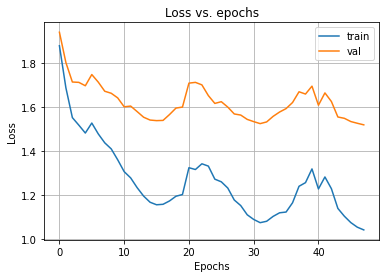

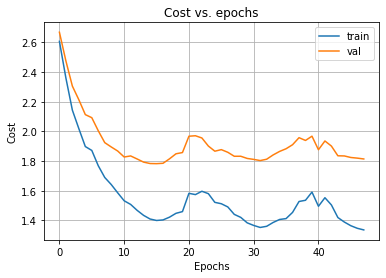

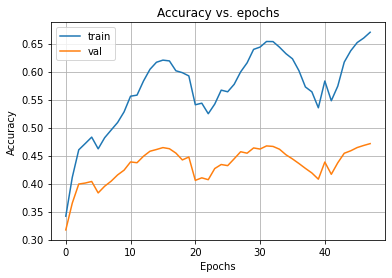

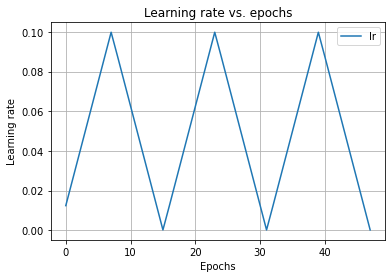

The test metrics are: {'accuracy': 0.4832}


In [7]:
coeff = 1.0
mean = 0.0
std = 0.01
params = {"coeff":coeff, "mean": mean, "std":None}

reg_rate_l2 = 0.025

in_dim = x_train.shape[1]
out_dim = np.unique(y_train).size
mid_dim = 50

seed = 200

dense_1 = \
    Dense(in_dim=in_dim, out_dim=mid_dim, 
          kernel_initializer=XavierInitializer(seed=seed, **params), 
          bias_initializer=XavierInitializer(seed=seed+1, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=ReLUActivation()
         )

dense_2 = \
    Dense(in_dim=mid_dim, out_dim=out_dim,
          kernel_initializer=XavierInitializer(seed=seed+2, **params), 
          bias_initializer=XavierInitializer(seed=seed+3, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=SoftmaxActivation()
         )

layers = [
    dense_1,
    dense_2
]

model = Model(layers)

loss = CategoricalCrossEntropyLoss()

# defined before
# n_epochs = 48
# batch_size = 100

lr_initial = 1e-5
lr_max = 1e-1
# defined before
# step_size = 800
lr_schedule = LRCyclingSchedule(lr_initial, lr_max, step_size)
optimizer = SGDOptimizer(lr_schedule=lr_schedule)

metrics = [AccuracyMetrics()]

model.compile_model(optimizer, loss, metrics)
print(model)

# verbosity level of fit
verbose = 2
history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size, verbose)

path_save_losses = "assets/two_layer/losses.png"
path_save_costs = "assets/two_layer/costs.png"
path_save_accuracies = "assets/two_layer/accuracies.png"
path_save_lrs = "assets/two_layer/lrs.png"
plot_losses(history, path_save_losses)
plot_costs(history, path_save_costs)
plot_accuracies(history, path_save_accuracies)
plot_lrs(history, path_save_lrs)

params_test = {"mode": "test"}
scores_test = model.forward(x_test, **params_test)
y_hat_test = np.argmax(scores_test, axis=1)
metrics_test = model.compute_metrics(y_test, scores_test)

print(f"The test metrics are: {metrics_test}")

Note that the reason for the learning rate curve to be shifted is that the learning rate is always recorded at the end of an epoch.

As shown in the results, the cylcial learning rate schedule increases and decrease the learning rate in cycles. This helps escape local minimia during optimization and achieve better model performance.

## Hyperparameter Search

The hyperparameter search is conducted for the combination of two hyperpaparameters - the learning rate and the L2 regularization strength. To do that, [hyperopt](#https://github.com/hyperopt/hyperopt), a Bayesian, distributed hyperparameter optimization library is used.

## best model

In [ ]:
# Load data
# train set is batch 1, val set is batch 2, test set is test
path = os.path.join("data", "data_batch_1")
x_train_img_1, y_train_1 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_2")
x_train_img_2, y_train_2 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_3")
x_train_img_3, y_train_3 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_4")
x_train_img_4, y_train_4 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_5")
x_train_img_5, y_train_5 = load_cfar10_batch(path)

x_train_val_img = np.vstack([x_train_img_1, x_train_img_2, x_train_img_3, x_train_img_4, x_train_img_5])
y_train_val = np.hstack([y_train_1, y_train_2, y_train_3, y_train_4, y_train_5])

x_train_img, x_val_img, y_train, y_val = train_test_split(x_train_val_img, y_train_val,
                                                          test_size=0.02, random_state=42)

path = os.path.join("data", "test_batch")
x_test_img, y_test = load_cfar10_batch(path)

# check counts in datasets
print(f"train set shape: {x_train_img.shape}, "
      f"val set shape: {x_val_img.shape}, test set shape: {x_test_img.shape}")
print(f"train labels shape: {y_train.shape},"
      f" val labels shape: {y_val.shape}, test labels shape: {y_test.shape}")

# assert balanced dataset
train_counts = np.unique(y_train, return_counts=True)[1]
train_ratios = train_counts / train_counts.sum()

val_counts = np.unique(y_val, return_counts=True)[1]
val_ratios = val_counts / val_counts.sum()

test_counts = np.unique(y_test, return_counts=True)[1]
test_ratios = test_counts / test_counts.sum()

# np.testing.assert_array_equal(train_ratios, val_ratios)
# np.testing.assert_array_equal(val_ratios, test_ratios)

#np.testing.assert_allclose(train_ratios, val_ratios, rtol=1e-1, atol=0)
#np.testing.assert_allclose(val_ratios, test_ratios, rtol=1e-1, atol=0)

# Pre-process data
x_train_un = x_train_img.reshape(x_train_img.shape[0], -1)
x_val_un = x_val_img.reshape(x_val_img.shape[0], -1)
x_test_un = x_test_img.reshape(x_test_img.shape[0], -1)

x_train = x_train_un / 255.
x_val = x_val_un / 255.
x_test = x_test_un / 255.

mean = np.mean(x_train, axis=0).reshape(1, x_train.shape[1])
std = np.std(x_train, axis=0).reshape(1, x_train.shape[1])

x_train = (x_train - mean) / std
x_val = (x_val - mean) / std
x_test = (x_test - mean) / std

In [ ]:
batch_size = 100

n_s = int(2*np.floor(x_train.shape[0] / batch_size))
print(f"step size of cyc. lr: {n_s} update steps")

cycle_steps = 2*n_s
print(f"full cycle of cyc.lr : {cycle_steps} update steps")

#print(cycle * batch_size)

epochs_one_full_cycle = (cycle_steps * batch_size) / x_train.shape[0]
print(f"{epochs_one_full_cycle} epochs = 1 full cycle = {cycle_steps} update steps")

n_cycle = 3
print(f"{n_cycle} cycle = {n_cycle*epochs_one_full_cycle} epochs = {n_cycle*cycle_steps} update steps")

In [ ]:
coeff = 1.0
mean = 0.0
std = 0.01
params = {"coeff":coeff, "mean": mean, "std":None}

#reg_rate_l2 = 0.1
# best obj:0.5134, with {'reg_rate_l2': 0.00036537637001811185}
reg_rate_l2 = best_params["reg_rate_l2"]
#print(reg_rate_l2)
#raise

in_dim = x_train.shape[1]
out_dim = 10
mid_dim = 50

seed = 200

dense_1 = \
    Dense(in_dim=in_dim, out_dim=mid_dim, 
          kernel_initializer=XavierInitializer(seed=seed, **params), 
          bias_initializer=XavierInitializer(seed=seed+1, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=ReLUActivation()
         )

dense_2 = \
    Dense(in_dim=mid_dim, out_dim=out_dim,
          kernel_initializer=XavierInitializer(seed=seed+2, **params), 
          bias_initializer=XavierInitializer(seed=seed+3, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=SoftmaxActivation()
         )

layers = [
    dense_1,
    dense_2
]

model = Model(layers)
print(model)

loss = CategoricalCrossEntropyLoss()

n_epochs = 12
batch_size = 100

#lr_initial = 0.01
#lr_schedule = LRConstantSchedule(lr_initial)
#decay_steps = n_epochs * 2
#decay_rate = 0.9
#lr_schedule = LRExponentialDecaySchedule(lr_initial, decay_steps, decay_rate)

lr_initial = 1e-5
lr_max = 1e-1
step_size = 980
lr_schedule = LRCyclingSchedule(lr_initial, lr_max, step_size)
optimizer = SGDOptimizer(lr_schedule=lr_schedule)

metrics = [AccuracyMetrics()]

model.compile_model(optimizer, loss, metrics)
history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size)

plot_losses(history)
plot_costs(history)
plot_accuracies(history)
plot_lr(history)

scores_test = model.forward(x_test)
y_hat_test = np.argmax(scores_test, axis=1)
acc_test = AccuracyMetrics().get_metrics(y_test, y_hat_test)

print(f"test acc: {acc_test}")